# Structure of this notebook

This notebook is a living document of analysis.
It consists of these parts:
1. preprocessing: stuff that applies to everyone e.g. imports, constants and data manipulation that is necessary for all subparts  of the analysis (setting, solution, evaluation)
2. generic analysis
3. specific analysis: analyses divided by subpart, e.g.
  1. Setting
  2. Solution
  3. Evaluation

This document requires seaborn == 0.9.0. See the `README.md` for package requirements.

## Imports and preprocessing

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import math
import datetime
import matplotlib
import requests
import re
import seaborn as sns
from pandas.tools.plotting import parallel_coordinates
import itertools

from matplotlib import dates

sns.set(style="whitegrid", font='Palatino')
sns.set_context("paper")
%matplotlib inline
current_palette = sns.color_palette()

# Input filename
RESULTS_FILENAME = '../collection/collection.csv'
# Filename for normalization of algorithm names
ALGO_CONVERSION_FILE = './algo_conversion.json'

# Questions
qs = {
    "setting": ["Domain",
                "Domain other",
                "Is suitability of actions explicitly defined by users?",
                "Is suitability of actions implicitly derived from observations on user behavior?",
                "Is safety mentioned as a concern in the application?",
                "Are models of user responses to system behavior available?",
                "Are data on human responses to system behavior available?",
                "Can new interactions with users be sampled with ease?",
                "Is privacy mentioned as a concern in the application?",
                "Can all information to base personalization on be measured directly?",
                ],
    "solution": ["Which algorithms are used?",
                 "How many learners are used?",
                 "Where are traits of individuals included?",
                 "Is training performed online or in batch?",
                 "Is training performed on a simulator?",
                 "Is training performed on static real life data?",
                 "Is training performed live, in a real-life setting?",
                 "Comma-separated list of all algorithms, ordered by performance (worst -> best)",
                ],
    "evaluation": ["Is an evaluation performed on a simulator?",
                   "Is an evaluation performed on static real life data?",
                   "Is a live evaluation performed in a real life setting?",
                   "Is a comparison with 'no personalization' performed?",
                   "Is there a comparison between RL/CB and other personalization techniques?",
                  ]
    }

params = {
   'axes.labelsize': 9,
   'text.fontsize': 9,
   'legend.fontsize': 9,
   'xtick.labelsize': 9,
   'ytick.labelsize': 9,
}
plt.rcParams.update(params)

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Read data and filter out excluded studies

In [2]:
# Read data
all_data = pd.read_csv(RESULTS_FILENAME, skiprows=1, parse_dates=['Year'])
all_data['Domain'] = all_data['Domain'].astype('category')

# Remove all excluded studies:
# - not eligible after full paper check
# - full paper not accessible (ResearchGate and author email)
condition = ~(all_data['Eligiblity result (automatic)'] == 'y')
data = all_data.drop(all_data[condition].index)

## Expand and normalize algorithm column
An example of original data input (1 row):
```
ID 	Reviewr	Title				Abstract						Which Algorithm...					Year
2 	Mark 	"Automatically.." 	"With the rapid..." 	[....]	Q learning, actor-critic rl	[....]	2018
```

And corresponding expanded and normalized output (2 rows):
```
ID 	Reviewr	Title				Abstract						Which Algorithm...					Year
2 	Mark 	"Automatically.." 	"With the rapid..." 	[....]	Q-Learning					[....]	2018
2 	Mark 	"Automatically.." 	"With the rapid..." 	[....]	Actor Critic				[....]	2018
```

Note that all data, including indices (!) are maintained in the expanded version. This eases correlating the expanded data to the original rows, but it should be taken into account when doing aggregations as some studies are duplicated in the expanded dataframe.

Uses the `algo_conversion.json` mapping file.

In [3]:
algo_col = 'Which algorithms are used?'

# TODO: remove fillna!
#data[algo_col] = data[algo_col].fillna("Missing")

# Open and read normalization mapping file
with open(ALGO_CONVERSION_FILE) as f:
    normalization_map = json.load(f)

# First extract a Series containing the expanded list with original indices
# TODO: does not take into account 'and' and ';' yet
algo_list = data.apply(lambda x: pd.Series(x[algo_col].split(',')), axis=1).stack().reset_index(level=1,drop=True)
algo_list.name = 'algorithm_original'

# Join it with the original data using original indices
algo_data = data.join(algo_list)

# Normalization function to apply to each item in the expanded algorithm list
def normalize(string):
    if string.strip() in normalization_map:
        return normalization_map[string.strip()].strip()
    else:
        # TODO Ali: other normalization?
        return string.strip()
    
# Apply normalization to each algorithm in list
algo_data['algorithm'] = algo_data['algorithm_original'].apply(normalize)

In [4]:
data['algorithms'] = algo_data['algorithm'].groupby(algo_data.index.get_level_values(0)).aggregate(lambda x: ','.join(x.unique()))

## Expand and normalize Keywords column

In [5]:
keywords_col = 'Keywords'

# First extract a Series containing the expanded list with original indices
# TODO: does not take into account 'and' and ';' yet
data[keywords_col] = data[keywords_col].fillna("")
keyword_list = data.apply(lambda x: pd.Series(x[keywords_col].replace(",", ";").split(";")), axis=1).stack().reset_index(level=1,drop=True)
keyword_list.name = 'keyword_original'

# Join it with the original data using original indices
keyword_data = data.join(keyword_list)

# # Normalization function to apply to each item in the expanded algorithm list
def normalize(string):
    return string.strip().lower()
    
# # # Apply normalization to each algorithm in list
keyword_data['keywords'] = keyword_data['keyword_original'].apply(normalize)

In [6]:
data['keywords'] = keyword_data['keywords'].groupby(keyword_data.index.get_level_values(0)).aggregate(lambda x: ';'.join(x.unique()))

## Preprocessing: normalize 'y' 'n' values to boolean and store separately

In [7]:
qs_normalized = {}
for k, l in qs.items():
    qs_normalized[k] = []
    for v in l:
        unique_values = set(data[v].unique())
        v_identifier = v + "_bool"
        qs_normalized[k].append(v_identifier)
        # TODO: remove np.nan fields!
        if unique_values == {'y', 'n', 'u', np.nan} or unique_values == {'y', 'n'}:
            print(v_identifier)
            data[v_identifier] = data[v] == 'y'
        else:
            data[v_identifier] = data[v]

# Rename domain to more simple names
data['Domain'] = data['Domain.1'].replace('Marketing / Commerce', 'Commerce')
data['Domain'] = data['Domain'].apply(lambda x: x.strip().replace("\n", ""))
data['Domain'] = data['Domain'].replace("Other, e.g. ...", "Other")
data['Domain'] = data['Domain'].replace('Domain Independent', 'Domain Indep.')

# Turn numeric data to str where appropriate
data[qs['solution'][1]] = data[qs['solution'][1]].astype('str')

Is training performed on a simulator?_bool
Is training performed on static real life data?_bool
Is training performed live, in a real-life setting?_bool
Is suitability of actions explicitly defined by users?_bool
Is suitability of actions implicitly derived from observations on user behavior?_bool
Is safety mentioned as a concern in the application?_bool
Are models of user responses to system behavior available?_bool
Are data on human responses to system behavior available?_bool
Can new interactions with users be sampled with ease?_bool
Is privacy mentioned as a concern in the application?_bool
Can all information to base personalization on be measured directly?_bool
Is an evaluation performed on a simulator?_bool
Is an evaluation performed on static real life data?_bool
Is a live evaluation performed in a real life setting?_bool
Is a comparison with 'no personalization' performed?_bool
Is there a comparison between RL/CB and other personalization techniques?_bool


## Check for faulty data

In [8]:
for c in qs:
    for q in qs[c]:
        nulls = data[q].isnull().sum()
        others = ~ ((data[q] == 'y') | (data[q] == 'n'))
        d_others = data[others]
        if others.sum() > 0:
            print("{}: {}".format(q, others.sum()))
            if others.sum() < 5:
                print(d_others[q].unique())
                print(d_others['Title'])
            if q not in {'Domain other',
                         'Comma-separated list of all algorithms, ordered by performance (worst -> best)'}:
                print(data[data[q].isnull()]['Title'])
            print()


Which algorithms are used?: 166
Series([], Name: Title, dtype: object)

How many learners are used?: 166
Series([], Name: Title, dtype: object)

Where are traits of individuals included?: 166
Series([], Name: Title, dtype: object)

Is training performed online or in batch?: 165
Series([], Name: Title, dtype: object)

Comma-separated list of all algorithms, ordered by performance (worst -> best): 166

Domain: 166
Series([], Name: Title, dtype: object)

Domain other: 166



## Assign Bibtex data from DOI

In [9]:
def get_bibtex_key(bibtex_entry):
    return str(bibtex_entry).split(",")[0].split("{")[-1]

def get_bibtex(doi):
    response = requests.get("http://dx.doi.org/"+str(doi), headers={"Accept": "text/bibliography;style=bibtex"})
    if response.status_code == 200:
        print('.', end="")
        return response.content.decode('utf-8')
    else:
        print('x', end="")
        return None

#data['bibtex_by_doi'] = data['DOI'].apply(get_bibtex)

In [10]:
def get_bibtex_author(bibtex_entry):
    author_start_str ="author={"
    author_start_pos = bibtex_entry.find(author_start_str) + len(author_start_str)
    if author_start_pos != -1:
        substr = bibtex_entry[author_start_pos:]
        return substr[:substr.find('},')]

def normalize_author(authorname):
    if ',' in authorname:
        return authorname
    elif ' ' in authorname:
        nameparts = authorname.split(' ')
        return nameparts[-1] + ", " + ' '.join(nameparts[:-1])
    else:
        print(authorname)
        return authorname

def get_author_sortkey(authornames):
    names = authornames.split(" and ")
    normalized = map(normalize_author, names)
    return " and ".join(normalized)
    
        

In [11]:
data['Bibtex_key'] = data['Bibtex'].apply(get_bibtex_key)
dups = data['Bibtex_key'].value_counts()
processed = set()
for idx in data[data.groupby('Bibtex_key')['Bibtex_key'].transform('size') == 2].index:
    entry = data.ix[idx]
    key = entry['Bibtex_key']
    if key not in processed:
        new_key = key + '_0'
        data.at[idx, 'Bibtex_key'] = new_key
        data.at[idx, 'Bibtex'] = entry['Bibtex'].replace(key, new_key)
        processed.add(key)

(data['Bibtex_key'].value_counts() > 1).sum()

1

In [12]:
relevant_cols = [
  'Title',
  'Abstract',
  'Keywords',
  'Domain',
  'Domain other',
  'Database',


  'How many learners are used?',
  'Where are traits of individuals included?',
  'Is training performed online or in batch?',
  'Is training performed on a simulator?',
  'Is training performed on static real life data?',
  'Is training performed live, in a real-life setting?',


  'Is an evaluation performed on a simulator?',
  'Is an evaluation performed on static real life data?',
  'Is a live evaluation performed in a real life setting?',
  "Is a comparison with 'no personalization' performed?",
  'Is there a comparison between RL/CB and other personalization techniques?',

  'Is suitability of actions explicitly defined by users?',
  'Is suitability of actions implicitly derived from observations on user behavior?',
  'Is safety mentioned as a concern in the application?',
  'Are models of user responses to system behavior available?',
  'Are data on human responses to system behavior available?',
  'Can new interactions with users be sampled with ease?',
  'Is privacy mentioned as a concern in the application?',
  'Can all information to base personalization on be measured directly?',

  'algorithms',
  'Source Title',
  'Authors',
  'Authors with affiliations',
  'Citation Count',
  'DOI',
  'Type',
  'Year',
  'Bibtex_key',
  'Bibtex',
]
#data.to_csv('../publications.csv', sep=',', columns=relevant_cols, index=False)

You can access the boolean values using the `qs_normalized` variable.
It is similarly structured as the `qs` variable defined a couple of cells above.
Using the boolean values makes some analyses easier, I recommend to use it :)

## Function to plot data over time

In [13]:
def plot_over_time(to_plot, data, add_absolute=False, xrange=None, fig=None, ax=None):
    def fill_missing_years(df, year_range, values_column, column_to_fill, value_to_fill=0):
        for d in year_range:
            for v in df[values_column].unique():
                if not ((df.Year == d) & (df[values_column] == v)).any():
                    df = df.append({'Year': d, values_column: v, column_to_fill: value_to_fill}, ignore_index=True)
        return df.sort_values('Year')

    start_year, end_year = xrange or (data['Year'].min().year, data['Year'].max().year + 1)
    date_range = pd.to_datetime([datetime.datetime(year, 1, 1) for year in range(start_year, end_year+1)])
    counts = data.groupby(['Year'])[to_plot].value_counts(normalize=True).rename('percentage').reset_index()
    counts = fill_missing_years(counts, date_range, to_plot, 'percentage')
    total_counts = data['Year'].value_counts().rename('total').reset_index()
    abs_counts = data.groupby(['Year'])[to_plot].value_counts().rename('absolute').reset_index()
    abs_counts = fill_missing_years(abs_counts, date_range, to_plot, 'absolute')

    unique_values = set(counts[to_plot])
    if len(unique_values - {'y', 'n', 'u'}) <= 0:
        counts = counts[counts[to_plot] == 'y']
        abs_counts = abs_counts[abs_counts[to_plot] == 'y']
    elif unique_values == {True, False}:
        counts = counts[counts[to_plot] == True]
        abs_counts = abs_counts[abs_counts[to_plot] == True]

    if add_absolute:
        if fig is None and ax is None:
            fig, ax = plt.subplots()
        ax.margins(x=.7)

        merged_counts = pd.merge(counts, abs_counts, how='outer', left_on=['Year', to_plot], right_on=['Year', to_plot])
        merged_counts = pd.merge(merged_counts, total_counts, how='outer', left_on=['Year'], right_on=['index'])
        merged_counts.set_index('Year')
        ax2 = merged_counts.plot.bar(ax=ax, position=0, width=.4, color=current_palette[1] + (.4,), y='total', label="all, absolute", secondary_y=True)
        ax3 = merged_counts.plot.bar(ax=ax2, position=0, width=.4, color=current_palette[1], y='absolute', label="yes, absolute", secondary_y=True,)        
        ax4 = merged_counts.plot.bar(ax=ax3, position=1, width=.4, color=current_palette[0], y="percentage", label="yes, relative")
        ax2.spines['left'].set_color(matplotlib.colors.rgb2hex(current_palette[0]))
        ax2.spines['right'].set_color(matplotlib.colors.rgb2hex(current_palette[1]))
        ax.tick_params(axis='y', colors=matplotlib.colors.rgb2hex(current_palette[0]))
        ax2.tick_params(axis='y', colors=matplotlib.colors.rgb2hex(current_palette[1]))
    else:
        ax = counts.plot.bar(x="Year", y="percentage")
        ax2 = None
        fig = None
    ax.get_legend().remove()
    xticklabels = date_range.strftime("%Y")
    xticklabels[-1] = ""
    ax.set_xticklabels(xticklabels)
    ax.set(ylim=(0,1))
    plt.sca(ax)
    plt.xticks(rotation=45)
    return fig, ax, ax2

## Function to plot data over domains

In [14]:
def plot_per_domain(to_plot, data):
    # Answers by domain - relative
    counts = data.groupby(['Domain'])[to_plot].value_counts(normalize=True).rename('percentage').reset_index()
    counts_total = data['Domain'].value_counts().rename('total').reset_index()
    counts_abs = data.groupby(['Domain'])[to_plot].value_counts().rename('absolute').reset_index()
    legend = True
    if len(set(counts[to_plot]) - {'y', 'n', 'u',}) == 0:
        counts = counts[counts[to_plot] == 'y']
        counts_abs = counts_abs[counts_abs[to_plot] == 'y']
    elif set(counts[to_plot].unique()) == {True, False}:
        counts = counts[counts[to_plot]]
        counts_abs = counts_abs[counts_abs[to_plot]]
#     print(counts_abs['absolute'])
#     for domain in data['Domain'].unique():
#         if counts[counts['Domain'] == domain].shape[0] == 0:
#             counts = counts.append({'Domain': domain, to_plot: 'y', 'percentage': 0.0}, ignore_index=True)
#             counts_abs = counts.append({'Domain': domain, to_plot: 'y', 'absolute': 0.0}, ignore_index=True)
#     print(counts_abs)

    merged_counts = pd.merge(counts[['Domain', 'percentage']], counts_total[['index', 'total']], left_on=['Domain'], right_on=['index'])
    merged_counts = pd.merge(merged_counts, counts_abs[['Domain', 'absolute']], left_on=['Domain'], right_on=['Domain'])

    fig, ax = plt.subplots()
    merged_counts = merged_counts.set_index('Domain').sort_index()
    merged_counts.plot.bar(ax=ax, position=1, color=current_palette[0], width=.25, y="percentage", label="yes, relative")
    ax2 = merged_counts.plot.bar(ax=ax, position=0, color=current_palette[1], width=.25, y="absolute",  secondary_y=True, label="yes, absolute")
    ax3 = merged_counts.plot.bar(ax=ax, position=0, color=current_palette[1] + (.4,), width=.25, y="total",  secondary_y=True, label="all, absolute")
    ax2.spines['left'].set_color(matplotlib.colors.rgb2hex(current_palette[0]))
    ax2.spines['right'].set_color(matplotlib.colors.rgb2hex(current_palette[1]))
    ax.tick_params(axis='y', colors=matplotlib.colors.rgb2hex(current_palette[0]))
    ax2.tick_params(axis='y', colors=matplotlib.colors.rgb2hex(current_palette[1]))
    ax.set(title=to_plot)

    ax.set(ylim=(0,1))
    plt.sca(ax)
    plt.xticks(rotation=45)
    return fig, ax, ax2


In [15]:
import copy
rcParams = copy.deepcopy(plt.rcParams)

In [16]:
myRcParams = copy.deepcopy(rcParams)
myRcParams['figure.figsize'] = (20,4)

plt.rcParams.update(rcParams)

## Generic: Number of studies in different stages

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


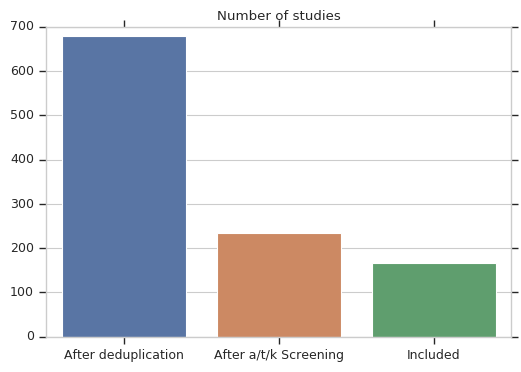

In [17]:
query_results = 680
after_screening = all_data.shape[0]
after_data_collection = data.shape[0]

ax = sns.barplot(x=('After deduplication', 'After a/t/k Screening', 'Included'), y=(query_results, after_screening, after_data_collection))
_ = ax.set(title='Number of studies')

## Is RL for personalization a trend?

First of all, it is interesting to see whether the number of applications of RL to personalization problems is growing.
We hypothesize there is a trend of increasing number of studies using RL for personalization.

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


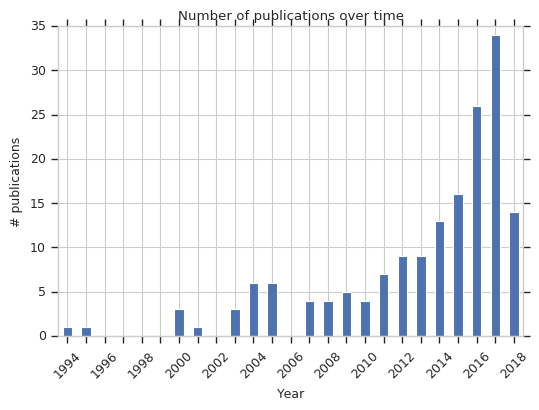

In [18]:
# myRcParams = copy.deepcopy(rcParams)
# ratio = 4 / 6
# base = 3
# myRcParams['figure.figsize'] = (base, base*ratio)
# plt.rcParams.update(myRcParams)

min_year = data['Year'].min().year
max_year = data['Year'].max().year

fig, ax = plt.subplots()
year_count = data.groupby('Year').count()
def fill_years(df, min_year=1994, max_year=2018, index=True):
    year_range = pd.to_datetime([datetime.datetime(year, 1, 1) for year in range(min_year, max_year+1)])
    for y in year_range:
        if not (df.Year == y).any():
            df = df.append({'Year': y, 'Unnamed: 0': 0}, ignore_index=True)
    if index:
        return df.set_index('Year').sort_index()
    else:
        return df

year_count = fill_years(year_count.reset_index())
ax = year_count.plot.bar(y='Unnamed: 0', ax=ax, label='Included')
xtick_labels = [yc if i % 2 == 0 else '' for i, yc in enumerate(year_count.index.strftime('%Y'))]
ax.set_xticklabels(xtick_labels)
ax.set_ylabel('# publications')
ax.set(title='Number of publications over time')
plt.xticks(rotation=45)
ax.get_legend().remove()

plt.savefig('imgs/no_publications_over_time.pdf', bbox_inches='tight')

#plt.rcParams.update(rcParams)

Overall, the graph shows a marked increase in studies that use RL for personalization. After some very early work in the mid 1990s, a period without any studies follows. From 2000 onward, the number of publications remains stable. Starting from 2011, however, the number of studies increases steeply and seems exponential. Note that the query was run on June 1st, 2018 explaining the sudden drop in that year.

We do not have any data on studies on personalization that do not use RL. As a result, we cannot answer the question whether the % of 'personalization' studies that use RL is increasing. Similarly so for the number of RL studies that focus on perosnalization.

## Which domains is RL for personalization applied to?

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


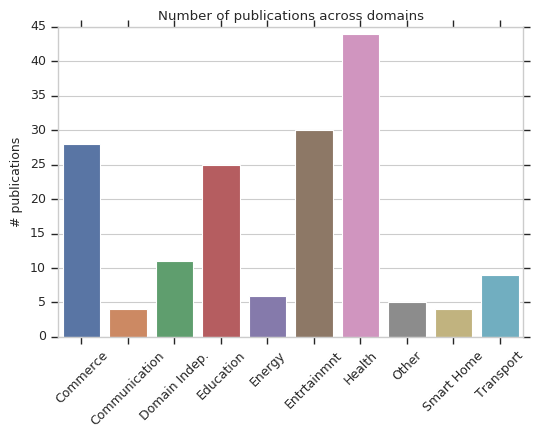

In [19]:
# myRcParams = copy.deepcopy(rcParams)
# ratio = 4 / 6
# base = 3
# myRcParams['figure.figsize'] = (base, base*ratio)
# plt.rcParams.update(myRcParams)

ax = sns.countplot('Domain', data=data, order=np.sort(data['Domain'].unique()))
ax.set(title="Number of publications across domains", xlabel="")
xtick_labels = np.sort(data['Domain'].replace('Entertainment', 'Entrtainmnt').unique())
ax.set_xticklabels(xtick_labels)
ax.set_ylabel('# publications')
_ = plt.xticks(rotation=45)
plt.savefig('imgs/no_publications_over_domains.pdf', bbox_inches='tight')

# plt.rcParams.update(rcParams)

Although some domains are more popular than others, personalization problems are addressed using RL in various application domains. Most notable is 'Health' being the most popular. Considering the trial-and-error nature of RL, Health may not have been the domain suspected to be most popular. Less surprising are the entertainment and commerce domains. These include many applications in recommender systems and advertisements. The education domain contains many applications of 'intelligent tutors' and curriculum generation.

The 'other' domains are....

In [20]:
other_domain_data = data[data['Domain'] == 'Other']['Domain other']
other_domain_data = other_domain_data.fillna('Missing')

other_domain_data.value_counts().sort_index()

Information filtering    1
Manufacturing            1
Missing                  1
Robotics                 1
Security                 1
Name: Domain other, dtype: int64

## Setting
Some analyses relevant to setting

In [21]:
for q in qs['setting'][2:]:
    v1, v2 = (data[q] == 'y').sum(), (data[q] == 'n').sum()
    print("{} \t {}\n{} & {}".format(v1+v2, q.strip(), v1, v2))

166 	 Is suitability of actions explicitly defined by users?
39 & 127
166 	 Is suitability of actions implicitly derived from observations on user behavior?
130 & 36
166 	 Is safety mentioned as a concern in the application?
30 & 136
166 	 Are models of user responses to system behavior available?
41 & 125
166 	 Are data on human responses to system behavior available?
66 & 100
166 	 Can new interactions with users be sampled with ease?
97 & 69
166 	 Is privacy mentioned as a concern in the application?
9 & 157
166 	 Can all information to base personalization on be measured directly?
132 & 34


/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


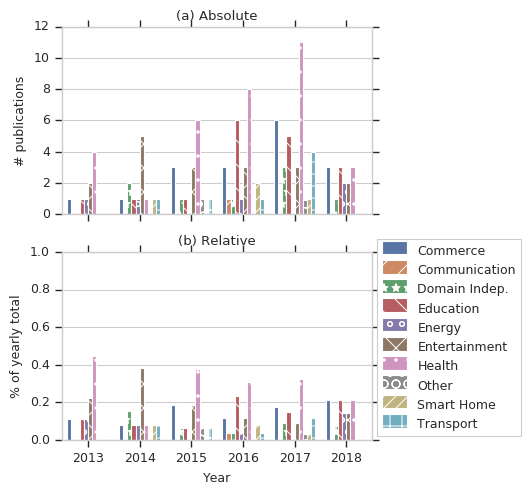

In [22]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 4
myRcParams['figure.figsize'] = (base, base*ratio *2)
plt.rcParams.update(myRcParams)

recent_data = data[data['Year'] > datetime.datetime(2012, 12, 31)]
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=myRcParams['figure.figsize'])
# f.tight_layout()

ax = sns.countplot(ax=ax1, x="Year", hue="Domain", hue_order=np.sort(data['Domain'].unique()), data=recent_data, )
years = pd.DatetimeIndex(np.sort(recent_data['Year'].unique())).strftime("%Y")
ax.set_xticklabels(years)
ax.get_legend().remove()
ax.set_ylabel('# publications')
ax.set(title='(a) Absolute')
ax.get_xaxis().set_label_text("")
ax.set_xticklabels([])

num_hues = len(data.Domain.unique())
hatches = itertools.cycle(['', '/', '*', '\\', 'o', 'x', '.', 'O', '//', '+'])
hatch_map = {}

for i, bar in enumerate(ax.patches):
    barcol = bar.get_facecolor()
    if barcol not in hatch_map:
        hatch_map[barcol] = next(hatches)
    bar.set_hatch(hatch_map[barcol])

rd_counts = (recent_data.groupby(['Year'])['Domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .reset_index()
                     .sort_values('Year'))
ax = sns.barplot(x="Year", y="percentage", hue="Domain", ax=ax2, hue_order=np.sort(data['Domain'].unique()), data=rd_counts)

for i, bar in enumerate(ax.patches):
    barcol = bar.get_facecolor()
    if barcol not in hatch_map:
        hatch_map[barcol] = next(hatches)
    bar.set_hatch(hatch_map[barcol])

ax.set_xticklabels(years)
leg = ax.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.5,1.1))
for patch in leg.get_patches():
    patch.set_height(10)
ax.set_ylabel('% of yearly total')
ax.set_ylim([0,1])
ax.set(title='(b) Relative')

plt.savefig('imgs/pub_per_dom_over_time.pdf', bbox_inches='tight')

plt.rcParams.update(rcParams)

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


'Are data on human responses to system behavior available?'

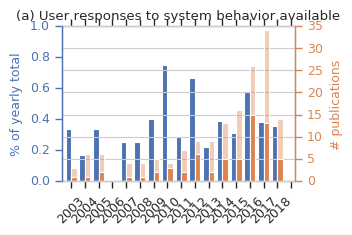

In [23]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

recent_data = data[data['Year'] > datetime.datetime(2002, 12, 31)]

to_plot = qs['setting'][6]

# min_year = recent_data['Year'].min().year
# max_year = recent_data['Year'].max().year
# d_to_plot = recent_data[to_plot]
# data[to_plot]
# rd_counts = (recent_data.groupby(['Year'])[to_plot]
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .reset_index()
#                      .sort_values('Year'))
# rd_counts = fill_years(rd_counts, min_year, max_year, index=False)
# years = pd.DatetimeIndex(np.sort(rd_counts['Year'].unique())).strftime("%Y")
# ax = sns.barplot(x="Year", y="percentage", hue=to_plot, hue_order=np.sort(d_to_plot.unique()), data=rd_counts)
# ax.set_xticklabels(years)
# ax.legend(loc='upper right', ncol=3)
# ax.set_ylabel('% of yearly total')
# plt.xticks(rotation=45)
# ax.set_ylim([0,1])
# ax.set(title=to_plot)
# # plt.savefig('imgs/pub_per_dom_over_time.pdf')

plt.figure()
fig, ax1, ax2 = plot_over_time(to_plot, recent_data, add_absolute=True)
ax1.set_ylabel("% of yearly total", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
ax1.set_title("(a) User responses to system behavior available")
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# fig.legend(handles+handles2, labels+labels2, loc='best', bbox_to_anchor=(1.58,.45))

plt.savefig('imgs/data_on_human_responses.pdf', bbox_inches='tight')

myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)
plt.rcParams.update(rcParams)
to_plot

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


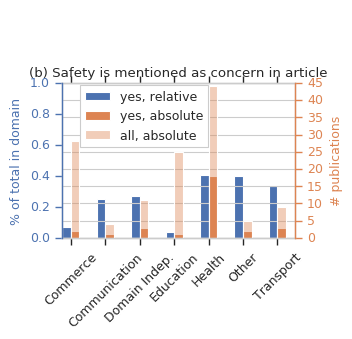

In [24]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

to_plot = qs['setting'][4]

d_to_plot = data[to_plot]
# rd_counts = (data.groupby(['Domain'])[to_plot]
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .reset_index()
#                      .sort_values('Domain'))
# ax = sns.barplot(x="Domain", y="percentage", hue=to_plot, hue_order=np.sort(d_to_plot.unique()),  data=rd_counts)
# ax.legend(loc='upper right', ncol=3)
# ax.set_ylabel('Occurence (%)')
# plt.xticks(rotation=45)
# ax.set_ylim([0,1])
# ax.set(title=to_plot)
plt.figure()
fig, ax1, ax2 = plot_per_domain(to_plot, data)
ax1.set(xlabel="")
ax1.get_legend().remove()
ax1.set_ylabel("% of total in domain", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
ax1.set_title("(b) Safety is mentioned as concern in article")
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles+handles2, labels+labels2, bbox_to_anchor=(.715,1.3))
plt.savefig('imgs/safety_mentioned.pdf', bbox_inches='tight')


plt.rcParams.update(rcParams)

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


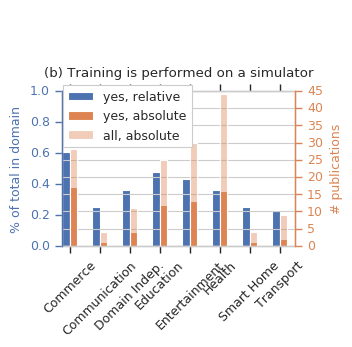

In [25]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

to_plot = qs['solution'][5]

d_to_plot = data[to_plot]
# rd_counts = (data.groupby(['Domain'])[to_plot]
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .reset_index()
#                      .sort_values('Domain'))
# ax = sns.barplot(x="Domain", y="percentage", hue=to_plot, hue_order=np.sort(d_to_plot.unique()),  data=rd_counts)
# ax.legend(loc='upper right', ncol=3)
# ax.set_ylabel('Occurence (%)')
# plt.xticks(rotation=45)
# ax.set_ylim([0,1])
# ax.set(title=to_plot)
plt.figure()
fig, ax1, ax2 = plot_per_domain(to_plot, data)
ax1.set(xlabel="")
ax1.get_legend().remove()
ax1.set_ylabel("% of total in domain", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
ax1.set_title("(b) Training is performed on a simulator")
ttl = ax1.title
ttl.set_position([.5, 1.05])
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles+handles2, labels+labels2, ncol=1,
           columnspacing=.5, bbox_to_anchor=(.66,1.34))

plt.savefig('imgs/solution_training_performed_simulator.pdf', bbox_inches='tight')
plt.rcParams.update(rcParams)

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


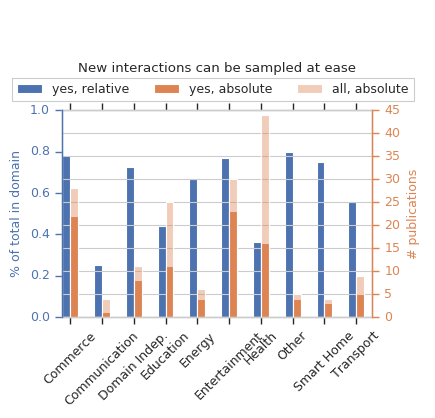

In [26]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 4
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

to_plot = qs['setting'][7]

plt.figure()
fig, ax1, ax2 = plot_per_domain(to_plot, data)
ax1.set(xlabel="")
ax1.get_legend().remove()
ax1.set_ylabel("% of total in domain", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
ax1.set_title("New interactions can be sampled at ease")
ttl = ax1.title
ttl.set_position([.5, 1.15])
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles+handles2, labels+labels2, ncol=3, bbox_to_anchor=(1.05,1.3))
plt.savefig('imgs/iteractions_can_be_sampled_with_ease.pdf', bbox_inches='tight')

plt.rcParams.update(rcParams)

## Solution: algorithm reuse
Let's see how many unique algorithms are mentioned and how many of them are ever reused.

Unique algo's mentioned: 71


/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


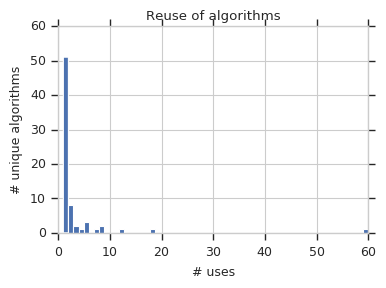

In [27]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 4
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

# NOTE: use a different dataframe now, the one with the expanded algorithm list
algo_uses = algo_data['algorithm'].value_counts()
print("Unique algo's mentioned: {}".format(len(algo_uses)))

ax = sns.distplot(algo_uses.tolist(), bins=max(algo_uses.tolist()), hist_kws={'alpha':1,}, kde=False, label='Uses')
ax.set(title='Reuse of algorithms')
ax.set(xlabel="# uses", ylabel="# unique algorithms")
plt.savefig('imgs/algorithm_reuse.pdf', bbox_inches='tight')

plt.rcParams.update(rcParams)

Most algorithms are never reused. A possible explanation is that top-ranked venues prefer theoretic / algorithmic / technical contributions. However, it is unclear whether all of these algorithm can be considered significantly novel. In any case, the large number of different algorithms makes it hard to gain insight into which algorithms are successful in which cases.

Let's have a look at the twenty most reused algorithms.

In [28]:
algo_uses.sort_values(ascending=False)[:20]

Q-Learning                            60
RL, not further specified             18
Contextual Bandits                    12
SARSA                                  8
Actor-Critic                           8
Inverse Reinforcement Learning         7
UCB                                    5
Policy Iteration                       5
LinUCB                                 5
Deep Reinforcement Learning            4
DQN                                    3
Fitted Q-Iteration                     3
DDQN                                   2
TD-Learning                            2
Monte Carlo                            2
DYNA-Q                                 2
Interactive Reinforcement Learning     2
Policy Gradient                        2
Thompson Sampling                      2
CLUB                                   2
Name: algorithm, dtype: int64

Q-Learning is the most used. Like some others in the top-20, such as SARSA, Actor-Critic and Policy Iteration, it is a well-established and generic algorithm. The top-20 further contains a lot of algorithms from the Contextual Bandit family, such as Contextual Bandits, UCB and LinUCB.

Another thing to note is the high diversity in reporting the algorithm used. Some are very precise whereas many papers just mention broad categories of families. specifically, 18 papers do not specify which algorithm they use. This is a serious concern to reproducabilty.

Finally, there is a relatively large number of studies in the 'Inverse Reinforcement Learning' category. In Martijn's & Marco's book (2012), they specifically mention that IRL has only seen successes in continuous control and that finding other application areas could yield interesting results. Personalization may be one of those application areas.

Let's have a look at the number of learners used...

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


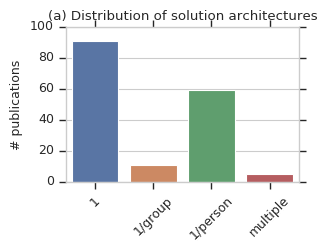

In [29]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

ax = sns.countplot(qs['solution'][1], data=data, order=np.sort(data[qs['solution'][1]].unique()))
ax.set(title="(a) Distribution of solution architectures", xlabel="", ylabel="# publications")
_ = plt.xticks(rotation=45)
plt.savefig('imgs/solution_number_of_learners_used.pdf', bbox_inches='tight')

plt.rcParams.update(rcParams)

Most solution architectures use a single model. Learning from interactions with many users has the benefit of a system that can yield reasonable performance for first-time users of the system. On the other end of the spectrum are 1/person architectures, in which every learner is exposed to experiences with one person only and therefore can optimize their policy to that single person to a greater extend than in 1-learner architecture.

The 1/group architecture can be considered as a middle ground between these former two. In it, only experiences with relevant individuals can be shared.
Although this architecture cover an interesting middle ground, it is not common. There may be interesting opportunities for future work in pooling experiences of users.

Let's have a look at the role of simulators v.s. training on static 'real' data or in a live setting

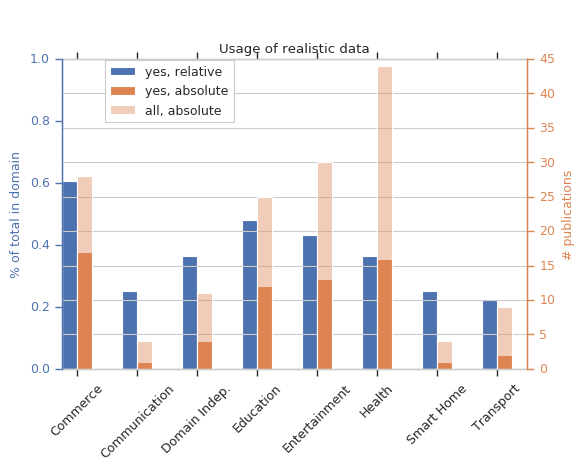

In [30]:
data['real training'] = (data[qs['solution'][5]] == 'y') | (data[qs['solution'][6]] == 'y')

plt.figure()
fig, ax1, ax2 = plot_per_domain(qs['solution'][5], data)
ax1.set(xlabel="")
ax1.get_legend().remove()
ax1.set_ylabel("% of total in domain", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
ax1.set_title("Usage of realistic data")
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles+handles2, labels+labels2, bbox_to_anchor=(.4, 1.04))

# plt.savefig('imgs/training_sim_per_domain.pdf', bbox_inches='tight')

In [31]:
data[(data[qs['solution'][4]] == 'y') & (data.Domain == 'Entertainment')]['real training'].sum()

9

In [32]:
q1 = qs['solution'][1]
q2 = qs['solution'][2]


data.pivot_table(values='Title', index=q2, columns=q1, 
                 aggfunc=lambda x: len(x.unique()))

How many learners are used?,1,1/group,1/person,multiple
Where are traits of individuals included?,,,,
not used,48.0,3.0,22.0,NaN
other,5.0,NaN,9.0,3.0
state representation,38.0,8.0,28.0,2.0


## Evaluation

Regarding evaluation, the first thing to look at is whether evaluations are becoming more realistic. Generally, technologies are first tested in 'toy' settings to study their properties. RL solutions are being used in contexts that involve humans increasingly (e.g. more papers). However, are these solutions robust enough for realistic evaluations? E.g. do we see a similar increase in the number of evaluations that involve humans?

In [33]:
n_algorithms = algo_data['Title'].groupby(algo_data.index).count()
data['n_algorithms'] = n_algorithms

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


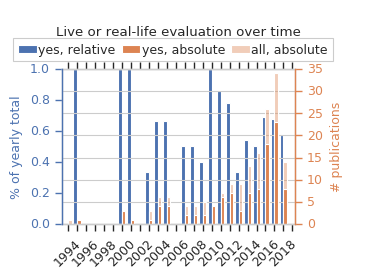

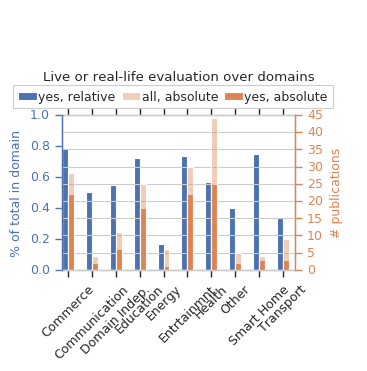

In [34]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

data['real evaluation'] = (data[qs['evaluation'][1]] == 'y') | (data[qs['evaluation'][2]] == 'y')
data['non-rl or no pers comparison'] = (data[qs['evaluation'][3]] == 'y') | (data[qs['evaluation'][4]] == 'y')
data['rl comparison'] = (data['n_algorithms'] >1)
data['rl plus non-rl'] = (data[qs['evaluation'][4]] == 'y') | (data['n_algorithms'] >1)
data['any comparison'] = (data[qs['evaluation'][3]] == 'y') | (data[qs['evaluation'][4]] == 'y') | (data['n_algorithms'] >1)
data['no comparison'] = ~data['any comparison']

fig, ax1, ax2 = plot_over_time('real evaluation', data, add_absolute=True)
ax1.set(title="Live or real-life evaluation over time")
ax1.set_ylabel("% of yearly total", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])

ttl = ax1.title
ttl.set_position([.5, 1.17])
fig.legend(handles+handles2, labels+labels2, ncol=3, bbox_to_anchor=(1.13,1.23), columnspacing=.5, handletextpad=.1, handlelength=1.5)

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
xtick_labels = [yc if i % 2 == 0 else '' for i, yc in enumerate(year_count.index.strftime('%Y'))]
ax1.set_xticklabels(xtick_labels)
# fig.legend(handles+handles2, labels+labels2, bbox_to_anchor=(.58,.9))
fig.savefig('imgs/realistic_eval_over_time.pdf', transparent=True, bbox_inches='tight')

plt.rcParams.update(rcParams)

myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

# Over-time plot of answers - relative
fig, ax1, ax2 = plot_per_domain('real evaluation', data)
ax1.set(xlabel="")
ax1.set(title="Live or real-life evaluation over domains")
ax1.get_legend().remove()
ax1.set_ylabel("% of total in domain", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
ttl = ax1.title
ttl.set_position([.5, 1.18])
xtick_labels = np.sort(data['Domain'].replace('Entertainment', 'Entrtainmnt').unique())
fig.legend(handles+handles2, labels+labels2, ncol=3, bbox_to_anchor=(1.13,1.46), columnspacing=.5, handletextpad=.1, handlelength=1.5)
ax1.set_xticklabels(xtick_labels)
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# fig.legend(handles+handles2, labels+labels2, ncol=2, bbox_to_anchor=(1.1, 1.09))
fig.savefig('imgs/realistic_eval_over_domains.pdf', transparent=True, bbox_inches='tight')
plt.rcParams.update(rcParams)


The graph shows a significant increase in realistic evaluations over time. It therefore seems that RL solutions hold in realistic settings, also in contexts that involve humans. Possible explanations: availability of data, improvement of algorithm performance, ability to do offline policy evaluation, trends in web/business(logical followup A/B testing), increasing quality of simulators.

The ratio of studies that evaluate on a realistic setting, however, does not show a clear pattern. The lack of a relative increase is alarming for the field. Apparently, many works still focus on POC contributions.

Let's see what's in these evaluations, e.g. whether a comparisons are made

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


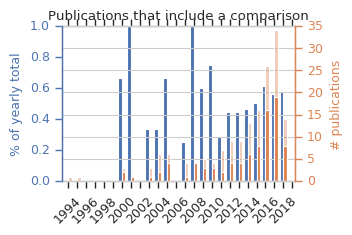

In [35]:
myRcParams = copy.deepcopy(rcParams)
ratio = 4 / 6
base = 3
myRcParams['figure.figsize'] = (base, base*ratio)
plt.rcParams.update(myRcParams)

fig, ax1, ax2 = plot_over_time('any comparison', data, add_absolute=True)
ax1.set(title="Publications that include a comparison")
ax1.set_ylabel("% of yearly total", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
xtick_labels = [yc if i % 2 == 0 else '' for i, yc in enumerate(year_count.index.strftime('%Y'))]
ax1.set_xticklabels(xtick_labels)
# fig.legend(handles+handles2, labels+labels2, bbox_to_anchor=(.8,.91))
fig.savefig('imgs/any_comparison_over_time.pdf', bbox_inches='tight')

plt.rcParams.update(rcParams)


This graph shows the ratio of studies that include any kind of comparison, specifically whether a comparison with 'no personalization', between RL methods or with non-rl methods is made. An alarming number of studies does not contain any comparison. This is a second alarming result as a high-quality research design would typically include some comparison.

Now let's compare these two criteria across domains...

/home/floris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Palatino'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


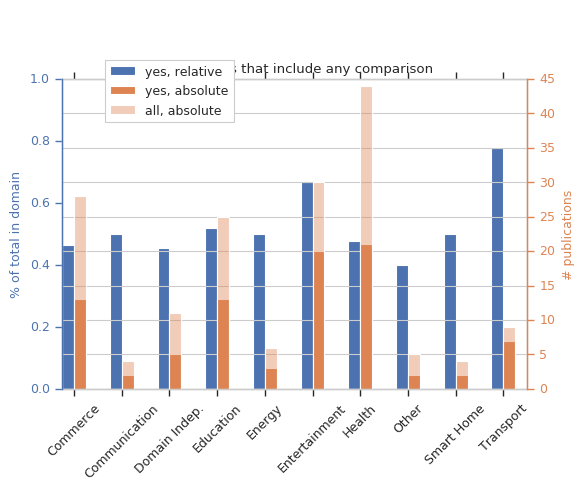

In [36]:
fig, ax1, ax2 = plot_per_domain('any comparison', data)
ax1.set(xlabel="")
ax1.set(title="Publications that include any comparison")
ax1.get_legend().remove()
ax1.set_ylabel("% of total in domain", color=current_palette[0])
ax2.set_ylabel("# publications", color=current_palette[1])
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles+handles2, labels+labels2, bbox_to_anchor=(.4, 1.09))
fig.savefig('imgs/any_comparison_over_domains.pdf', bbox_inches='tight')

Disregarding 'Smart Home' for now as it has only four studies, Most notable is that the popular domains 'Commerce' and 'Entertainment' contain relatively the most real evaluations. Possible explanations: availability of data, improvement of algorithm performance, ability to do offline policy evaluation, trends in web/business(logical followup A/B testing). These may also be domains that are not very safety critical, in contrast with 'Health'.

Can we explain these differences using the framework of different settings? Let's have a look at possible reasons for a lack of realistic evaluation. Finding one might provide some directions for future work. Let's split the studies by realism of evaluation and see whether the settings differ between parts in the following aspects: mention of safety, availability of user models (may make simulation easier), whether data on human responses are available upfront and whether privacy is mentioned as a concern.

In [37]:
q_s = qs_normalized['setting']
criterion = 'real evaluation'

data['possible reasons no evaluation'] = data[q_s[4]] | ~data[q_s[6]] | ~data[q_s[7]]
data['possible reasons no evaluation2'] = ~data[q_s[4]] & data[q_s[6]] & data[q_s[7]]

not_real = data[~data[criterion]]
real = data[data[criterion]]

print("Sample sizes: "+ str(real.shape[0]) + " v.s. " + str(not_real.shape[0]))
for q in q_s[4:9]:
    print('\t\t' + q[:-len('__bool')])
    print('\t\t  y   % \t  n   %')
    n_not_real = not_real.shape[0]
    n_real = real.shape[0]
    n_q_not_real = not_real[q].sum()
    n_q_real = real[q].sum()  
    print('real. eval.: ', end='\t')
    print("{0:3} {1:6.3f}".format(n_q_real, n_q_real / n_real), end='\t')
    print("{0:3} {1:6.3f}".format(n_real - n_q_real, 1-(n_q_real / n_real)))
    print('no real. eval.: ', end='')
    print("{0:3} {1:6.3f}".format(n_q_not_real, n_q_not_real / n_not_real), end='\t')
    print("{0:3} {1:6.3f}".format(n_not_real - n_q_not_real, 1-(n_q_not_real / n_not_real)))
    print('difference: ', end='\t')
    print("{0:3} {1:7.4f}".format(n_q_not_real - n_q_real, n_q_not_real / n_not_real - n_q_real / n_real), end='\t')
    print("{0:3} {1:7.4f}".format((n_not_real - n_q_not_real) - (n_real - n_q_real), (1-(n_q_not_real / n_not_real)) - (1-(n_q_real / n_real))))
    print()

Sample sizes: 104 v.s. 62
		Is safety mentioned as a concern in the application
		  y   % 	  n   %
real. eval.: 	 14  0.135	 90  0.865
no real. eval.:  16  0.258	 46  0.742
difference: 	  2  0.1234	-44 -0.1234

		Are models of user responses to system behavior available
		  y   % 	  n   %
real. eval.: 	 21  0.202	 83  0.798
no real. eval.:  20  0.323	 42  0.677
difference: 	 -1  0.1207	-41 -0.1207

		Are data on human responses to system behavior available
		  y   % 	  n   %
real. eval.: 	 57  0.548	 47  0.452
no real. eval.:   9  0.145	 53  0.855
difference: 	-48 -0.4029	  6  0.4029

		Can new interactions with users be sampled with ease
		  y   % 	  n   %
real. eval.: 	 60  0.577	 44  0.423
no real. eval.:  37  0.597	 25  0.403
difference: 	-23  0.0199	-19 -0.0199

		Is privacy mentioned as a concern in the application
		  y   % 	  n   %
real. eval.: 	  7  0.067	 97  0.933
no real. eval.:   2  0.032	 60  0.968
difference: 	 -5 -0.0350	-37  0.0350



There are 63 studies with no real evaluation versus 104 with a real evaluation. Because of this difference in group size, it's more interesting to look at differences in ratios.

The biggest difference between studies with and without a realistic evaluation is the upfront availability of data on interactions with users. This is not surprising, as it is natural to use existing interactions for evaluation when they are available already.

The second biggest difference between the groups is whether safety is mentioned as a concern. Relatively, studies that refrain from a realistic evaluation mention safety concerns almost twice as often as studies that do a realistic evaluation.

The third biggest difference can be found in availability of user models. If a model is available, user responses could be simulated more easily.

Surprisingly, the ease of sampling interactions seems not so different between studies with a realistic and without realistic evaluation.

# Reference table

In [ ]:
def to_citation(x):
    return "\cite{{{}}}".format(str(x))

data.groupby(qs['setting'][0])['Bibtex_key'].aggregate(lambda x: ','.join( map(to_citation, x)))

In [ ]:
data.sort_values('Bibtex_author').groupby(qs['setting'][0])['Bibtex_key'].aggregate(lambda x: ','.join( map(to_citation, x)))

In [76]:
qs_id = {
    "setting": [("Domain", "Domain"),
                ("Domain other", "Domain other"),
                ("Is suitability of actions explicitly defined by users?", 1),
                ("Is suitability of actions implicitly derived from observations on user behavior?", 2),
                ("Is safety mentioned as a concern in the application?", 3),
                ("Are models of user responses to system behavior available?", 5),
                ("Are data on human responses to system behavior available?", 6),
                ("Can new interactions with users be sampled with ease?", 7),
                ("Is privacy mentioned as a concern in the application?", 4),
                ("Can all information to base personalization on be measured directly?", 8),
                ],
    "solution": [("Which algorithms are used?", 9),
                 ("How many learners are used?", 10),
                 ("Where are traits of individuals included?", 11),
                 ("Is training performed online or in batch?", 12),
                 ("Is training performed on a simulator?", 13),
                 ("Is training performed on static real life data?", 14),
                 ("Is training performed live, in a real-life setting?", 15),
                 ("Comma-separated list of all algorithms, ordered by performance (worst -> best)", "algo_list"),
                ],
    "evaluation": [("Is an evaluation performed on a simulator?", 16),
                   ("Is an evaluation performed on static real life data?", 17),
                   ("Is a live evaluation performed in a real life setting?", 18),
                   ("Is a comparison with 'no personalization' performed?", 19),
                   ("Is there a comparison between RL/CB and other personalization techniques?", 20),
                  ]
    }

In [ ]:
# format 1
qs_ids_f = []
for g in qs_id:
    for (q, q_id) in qs_id[g]:
        qs_ids_f.append((q, q_id))

sorted_by_author = data.sort_values('Bibtex_author_sortkey')
with open("monster-table-1.tex", "w") as tf:
    for (q, q_id) in filter(lambda x: x[1] not in {'Domain other', "algo_list", 9},
                            sorted(qs_ids_f, key=lambda x: x[1] if (type(x[1]) == int) else 9999)):
        row = sorted_by_author.groupby(q)['Bibtex_key'].aggregate(lambda x: ' '.join( map(to_citation, x)))
        tf.write("{}".format(q_id))
        first = True
        for a, citations in row.items():
            if not first:
                tf.write(" \cline{2-3} \n")
            first = False
            tf.write("\n & {} \n & {} \\\\".format(a, citations))
        tf.write("\midrule\n\n")

In [ ]:
# format 2
sorted_by_author = data.sort_values('Bibtex_author_sortkey')
with open("monster-table-2.tex", "w") as tf:
    for (q, q_id) in filter(lambda x: x[1] not in {'Domain other', 'Domain', "algo_list", 9},
                            sorted(qs_ids_f, key=lambda x: x[1] if (type(x[1]) == int) else 9999)):
        row = sorted_by_author.groupby(q)['Bibtex_key'].aggregate(lambda x: ' '.join( map(to_citation, x)))
        tf.write("{}".format(q_id))
        for a, citations in row.items():
            tf.write("\n & {}".format(citations))
        tf.write(" \\\\\midrule\n\n")

In [ ]:
# format 3
qs_ids_f = []
for g in qs_id:
    for (q, q_id) in qs_id[g]:
        qs_ids_f.append((q, q_id))

sorted_by_author = data.sort_values('Bibtex_author_sortkey')
with open("monster-table-3.tex", "w") as tf:
    for (q, q_id) in filter(lambda x: x[1] not in {'Domain other', "algo_list", 9},
                            sorted(qs_ids_f, key=lambda x: x[1] if (type(x[1]) == int) else 9999)):
        row = '\cite{' + sorted_by_author.groupby(q)['Bibtex_key'].aggregate(lambda x: ', '.join(x)) + "}"
        tf.write("{}".format(q_id))
        first = True
        for a, citations in row.items():
            if not first:
                tf.write(" \cline{2-3} \n")
            first = False
            tf.write("\n & {} \n & {} \\\\".format(a, citations))
        tf.write("\midrule\n\n")

In [ ]:
with open("generated.bib", "w") as tf:
    tf.write("\n".join(data['Bibtex']))

## Analyse keyword usage

In [38]:
# NOTE: use a different dataframe now, the one with the expanded algorithm list
keyword_uses = keyword_data['keywords'].value_counts()
print("Unique keywords mentioned: {}".format(len(keyword_uses)))
keyword_uses

Unique keywords mentioned: 335


                                                   63
reinforcement learning                             62
personalization                                    14
recommender systems                                11
machine learning                                    9
q-learning                                          5
contextual bandits                                  5
markov decision process                             5
contextual bandit                                   4
user profiling                                      4
online learning                                     4
legibility                                          3
web personalization                                 3
conversational recommender systems                  3
dynamic treatment regime                            3
intelligent agents                                  3
personalized medicine                               3
content adaptation                                  3
intelligent agent           